System information (for reproducibility):

In [1]:
versioninfo()

Julia Version 1.8.5
Commit 17cfb8e65ea (2023-01-08 06:45 UTC)
Platform Info:
  OS: macOS (arm64-apple-darwin21.5.0)
  CPU: 12 × Apple M2 Max
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, apple-m1)
  Threads: 8 on 8 virtual cores
Environment:
  JULIA_NUM_THREADS = 8
  JULIA_EDITOR = code


Load packages:

In [2]:
using Pkg

Pkg.activate(pwd())
Pkg.instantiate()
Pkg.status()

  Activating project at `~/Documents/github.com/ucla-biostat-257/2023spring/slides/16-cond`


Status `~/Documents/github.com/ucla-biostat-257/2023spring/slides/16-cond/Project.toml`
  [2913bbd2] StatsBase v0.33.21
  [f3b207a7] StatsPlots v0.15.4
  [8bb1440f] DelimitedFiles
  [37e2e46d] LinearAlgebra


* Assume $\mathbf{A} \in \mathbb{R}^{n \times n}$ is nonsingular and consider the system of linear equation 
$$
\mathbf{A} \mathbf{x} = \mathbf{b}.
$$
The solution is 
$$
\mathbf{x} = \mathbf{A}^{-1}  \mathbf{b}.
$$
We want to know how the solution changes with a small perturbation of the input $\mathbf{b}$ (or $\mathbf{A}$).

* Let 
$$
\mathbf{b}_{\text{new}} = \mathbf{b} + \Delta \mathbf{b}.
$$
Then 
$$
\mathbf{x}_{\text{new}} = \mathbf{A}^{-1} (\mathbf{b} + \Delta \mathbf{b}) = \mathbf{x} + \Delta \mathbf{x}.
$$
Thus 
$$
\|\Delta \mathbf{x}\| = \|\mathbf{A}^{-1} \Delta \mathbf{b}\| \le \|\mathbf{A}^{-1}\| \|\Delta \mathbf{b}\|.
$$
Because $\mathbf{b} = \mathbf{A} \mathbf{x}$, 
$$
\frac{1}{\|\mathbf{x}\|} \le \|\mathbf{A}\| \frac{1}{\|\mathbf{b}\|}.
$$
This results 
$$
\frac{ \|\Delta \mathbf{x}\|}{\|\mathbf{x}\|} \le \|\mathbf{A}\|\|\mathbf{A}^{-1}\| \frac{\|\Delta \mathbf{b}\|}{\|\mathbf{b}\|}.
$$

* $\kappa(\mathbf{A}) = \|\mathbf{A}\| \|\mathbf{A}^{-1}\|$ is called the **condition number for linear equation**. It depends on the matrix norm being used.  
    * $\kappa_p$ means condition number defined from matrix-$p$ norm.

* Large condition number means "bad".

* Some facts:  
$$
\begin{eqnarray*}
\kappa(\mathbf{A}) &=& \kappa(\mathbf{A}^{-1})	\\
\kappa(c\mathbf{A}) &=& \kappa(\mathbf{A})	\\
\kappa(\mathbf{A}) &\ge& 1	\\
%\kappa_1(\mathbf{A}) &=& \kappa_\infty (\mathbf{A}^T)	\\
\kappa_2 (\mathbf{A}) &=& \kappa_2 (\mathbf{A}^T) = \frac{\sigma_1(\mathbf{A})}{\sigma_n(\mathbf{A})}	\\
\kappa_2(\mathbf{A}^T \mathbf{A}) &=& \frac{\lambda_1(\mathbf{A}^T \mathbf{A})}{\lambda_n(\mathbf{A}^T \mathbf{A})} =  \kappa_2^2(\mathbf{A}) \ge \kappa_2(\mathbf{A}).
\end{eqnarray*}
$$
The last fact says that the condition number of $\mathbf{A}^T \mathbf{A}$ can be much larger than that of $\mathbf{A}$.

* The smallest singular value $\sigma_n$ indicates the _distance to the trouble_.

* **Condition number for the least squares problem** is more complicated. Roughly speaking, 
    - the method based on normal equation (Cholesky, sweep) has a condition depending on $[\kappa_2(\mathbf{X})]^2$ 
    - QR for a _small residuals_ least squares problem has a condition depending on $\kappa_2(\mathbf{X})$
    
* Consider the simple case
$$
\begin{eqnarray*}
	\mathbf{X} = \begin{pmatrix}
	1 & 1 \\
	10^{-3} & 0 \\
	0 & 10^{-3}
	\end{pmatrix}.
\end{eqnarray*}
$$
Forming normal equation yields a singular Gramian matrix
$$
\begin{eqnarray*}
	\mathbf{X}^T \mathbf{X} = \begin{pmatrix}
	1 & 1 \\
	1 & 1
	\end{pmatrix}
\end{eqnarray*}
$$
if executed with a precision of 6 decimal digits.

## Implementation

* Julia function [`cond`](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.cond) computes $\kappa_p$ for $p=1$, 2 (default), or $\infty$.

* Julia function [`condskeel`](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.condskeel) computes the Skeel condition number.

## Longley example

The [Longley (1967)](https://www.jstor.org/stable/2283673?seq=1#page_scan_tab_contents) macroeconomic data set is a famous test example for numerical software in early days.

In [3]:
using DelimitedFiles, LinearAlgebra, StatsBase, StatsPlots

longley = readdlm("longley.txt")

16×7 Matrix{Float64}:
 60323.0   83.0  234289.0  2356.0  1590.0  107608.0  1947.0
 61122.0   88.5  259426.0  2325.0  1456.0  108632.0  1948.0
 60171.0   88.2  258054.0  3682.0  1616.0  109773.0  1949.0
 61187.0   89.5  284599.0  3351.0  1650.0  110929.0  1950.0
 63221.0   96.2  328975.0  2099.0  3099.0  112075.0  1951.0
 63639.0   98.1  346999.0  1932.0  3594.0  113270.0  1952.0
 64989.0   99.0  365385.0  1870.0  3547.0  115094.0  1953.0
 63761.0  100.0  363112.0  3578.0  3350.0  116219.0  1954.0
 66019.0  101.2  397469.0  2904.0  3048.0  117388.0  1955.0
 67857.0  104.6  419180.0  2822.0  2857.0  118734.0  1956.0
 68169.0  108.4  442769.0  2936.0  2798.0  120445.0  1957.0
 66513.0  110.8  444546.0  4681.0  2637.0  121950.0  1958.0
 68655.0  112.6  482704.0  3813.0  2552.0  123366.0  1959.0
 69564.0  114.2  502601.0  3931.0  2514.0  125368.0  1960.0
 69331.0  115.7  518173.0  4806.0  2572.0  127852.0  1961.0
 70551.0  116.9  554894.0  4007.0  2827.0  130081.0  1962.0

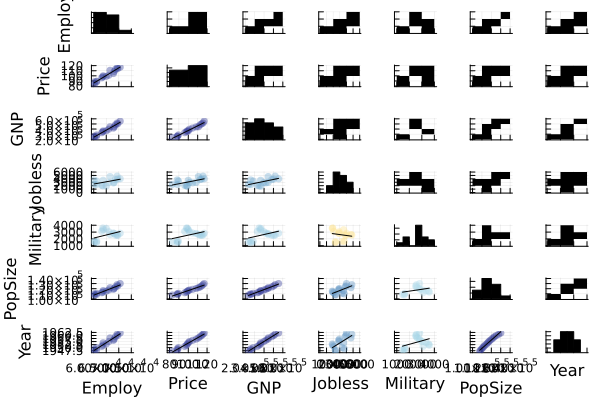

In [4]:
gr()

corrplot(longley, 
    label = ["Employ" "Price" "GNP" "Jobless" "Military" "PopSize" "Year"])

In [5]:
# response: Employment
y = longley[:, 1]
# predictor matrix
X = [ones(length(y)) longley[:, 2:end]]

16×7 Matrix{Float64}:
 1.0   83.0  234289.0  2356.0  1590.0  107608.0  1947.0
 1.0   88.5  259426.0  2325.0  1456.0  108632.0  1948.0
 1.0   88.2  258054.0  3682.0  1616.0  109773.0  1949.0
 1.0   89.5  284599.0  3351.0  1650.0  110929.0  1950.0
 1.0   96.2  328975.0  2099.0  3099.0  112075.0  1951.0
 1.0   98.1  346999.0  1932.0  3594.0  113270.0  1952.0
 1.0   99.0  365385.0  1870.0  3547.0  115094.0  1953.0
 1.0  100.0  363112.0  3578.0  3350.0  116219.0  1954.0
 1.0  101.2  397469.0  2904.0  3048.0  117388.0  1955.0
 1.0  104.6  419180.0  2822.0  2857.0  118734.0  1956.0
 1.0  108.4  442769.0  2936.0  2798.0  120445.0  1957.0
 1.0  110.8  444546.0  4681.0  2637.0  121950.0  1958.0
 1.0  112.6  482704.0  3813.0  2552.0  123366.0  1959.0
 1.0  114.2  502601.0  3931.0  2514.0  125368.0  1960.0
 1.0  115.7  518173.0  4806.0  2572.0  127852.0  1961.0
 1.0  116.9  554894.0  4007.0  2827.0  130081.0  1962.0

In [6]:
# Julia function for obtaining condition number
cond(X)

4.859257015454896e9

In [7]:
# we see the smallest singular value (aka trouble number) is very small
xsvals = svdvals(X)

7-element Vector{Float64}:
     1.6636682278894703e6
 83899.57794622087
  3407.1973760958635
  1582.6436810037953
    41.69360109707235
     3.648093794799694
     0.0003423709062101806

In [8]:
# condition number of the design matrix
xcond = maximum(xsvals) / minimum(xsvals)

4.859257015454896e9

In [9]:
# X is full rank from SVD
xrksvd = rank(X)

7

In [10]:
# least squares from QR
X \ y

7-element Vector{Float64}:
   -3.4822586345972517e6
   15.061872271479725
   -0.03581917929262435
   -2.0202298038170983
   -1.0332268671734908
   -0.05110410565372417
 1829.1514646142948

In [11]:
# Gram matrix
G = X'X

7×7 Matrix{Float64}:
    16.0        1626.9        6.20318e6   …  1.87878e6  31272.0
  1626.9           1.67172e5  6.46701e8      1.9214e8       3.18054e6
     6.20318e6     6.46701e8  2.55315e12     7.3868e11      1.21312e10
 51093.0           5.28908e6  2.06505e10     6.06649e9      9.99059e7
 41707.0           4.29317e6  1.66329e10     4.92386e9      8.15371e7
     1.87878e6     1.9214e8   7.3868e11   …  2.2134e11      3.67258e9
 31272.0           3.18054e6  1.21312e10     3.67258e9      6.11215e7

In [12]:
# rank of Gram matrix from SVD
# rank deficient! We lost precision when forming Gram matrix
rank(G)

6

In [13]:
svdvals(G)

7-element Vector{Float64}:
    2.76779197248889e12
    7.039139179553984e9
    1.1608993959674533e7
    2.504761021021242e6
 1738.3563724357014
   13.30858834767374
    1.1608070293864485e-7

In [14]:
# rank of Gram matrix from cholesky
# full!
gchol = cholesky(Symmetric(G), Val(true))
rank(gchol)

7

In [15]:
# least squares solution from Cholesky matches those from QR
gchol \ (X'y)

7-element Vector{Float64}:
   -3.4822586014639004e6
   15.061871749266937
   -0.03581917830516929
   -2.020229788972289
   -1.0332268628394854
   -0.05110410883399209
 1829.1514476542807

* Now let us re-run above example using **single precision**. (Pretend we are in the 60s-70s.)

In [16]:
Xsp = Float32.(X)
ysp = Float32.(y)

# least squares by QR: dramatically different from Float64 solution
Xsp \ ysp

7-element Vector{Float32}:
   0.023723926
 -52.99486
   0.071073264
  -0.42346406
  -0.5725658
  -0.41420248
  48.417835

In [17]:
# least squares by Cholesky: failed
G = Xsp'Xsp
gchol = cholesky(Symmetric(G), Val(true), check=false)
gchol \ (Xsp'ysp)

7-element Vector{Float32}:
     -4.2949673f10
     -1.1732868f6
   -798.16144
 -13540.074
  -5180.135
   -634.9445
      2.226134f7

In [18]:
rank(Xsp)

6

In [19]:
# rank of Gram matrix by Cholesky
rank(gchol)

6

In [20]:
# rank of Gram matrix by SVD
rank(G)

4

* **Standardizing the predictors** improves the condition.

In [21]:
# center and standardize matrix along dimension 1
Xcs = zscore(X[:, 2:end], 1)
Xcs = [ones(length(y)) Xcs]

16×7 Matrix{Float64}:
 1.0  -1.7311     -1.54343    -0.896035  -1.46093    -1.41114     -1.57532
 1.0  -1.22144    -1.29053    -0.929209  -1.65348    -1.26393     -1.36527
 1.0  -1.24924    -1.30434     0.52296   -1.42357    -1.0999      -1.15523
 1.0  -1.12878    -1.03727     0.168746  -1.37471    -0.933713    -0.945189
 1.0  -0.50792    -0.590809   -1.17106    0.707427   -0.768965    -0.735147
 1.0  -0.331857   -0.409472   -1.34977    1.41872    -0.597174    -0.525105
 1.0  -0.248458   -0.224493   -1.41612    1.35118    -0.334958    -0.315063
 1.0  -0.155793   -0.247361    0.411666   1.0681     -0.173229    -0.105021
 1.0  -0.0445951   0.0983004  -0.309603   0.634143   -0.00517531   0.105021
 1.0   0.270466    0.316732   -0.397353   0.359686    0.188324     0.315063
 1.0   0.622593    0.554058   -0.275358   0.274906    0.434295     0.525105
 1.0   0.84499     0.571936    1.59202    0.0435575   0.650652     0.735147
 1.0   1.01179     0.955839    0.663147  -0.0785831   0.854214     0.

In [22]:
cond(Xcs)

110.54415344231369

In [23]:
rank(Xcs)

7

In [24]:
rank(Xcs'Xcs)

7

## Further reading

* Chapter 6 of [Numerical Analysis for Statisticians](http://ucla.worldcat.org/title/numerical-analysis-for-statisticians/oclc/793808354&referer=brief_results) of Kenneth Lange (2010).

* Section 2.6 of [Matrix Computation](http://catalog.library.ucla.edu/vwebv/holdingsInfo?bibId=7122088) by Gene Golub and Charles Van Loan (2013).